# Nasdaq Composite 日足 メディアン統計

In [1]:
import sys
path_up = '..'
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import yfinance as yf

from funcs.technical import calc_robust_bollinger

In [3]:
code = 'IXIC'
symbol = '^%s' % code
ticker = yf.Ticker(symbol)

In [4]:
# 日足で過去 2 年分のデータを取得
df0 = ticker.history(period='5y', interval='1d')
 
# ローソク足のチャートには、そのうち過去 1 年分のみ使用する
dt_last = df0.index[len(df0) - 1]
tdelta_1y =  datetime.timedelta(days=365)
df = df0[df0.index >= dt_last - tdelta_1y]

## Moving Median

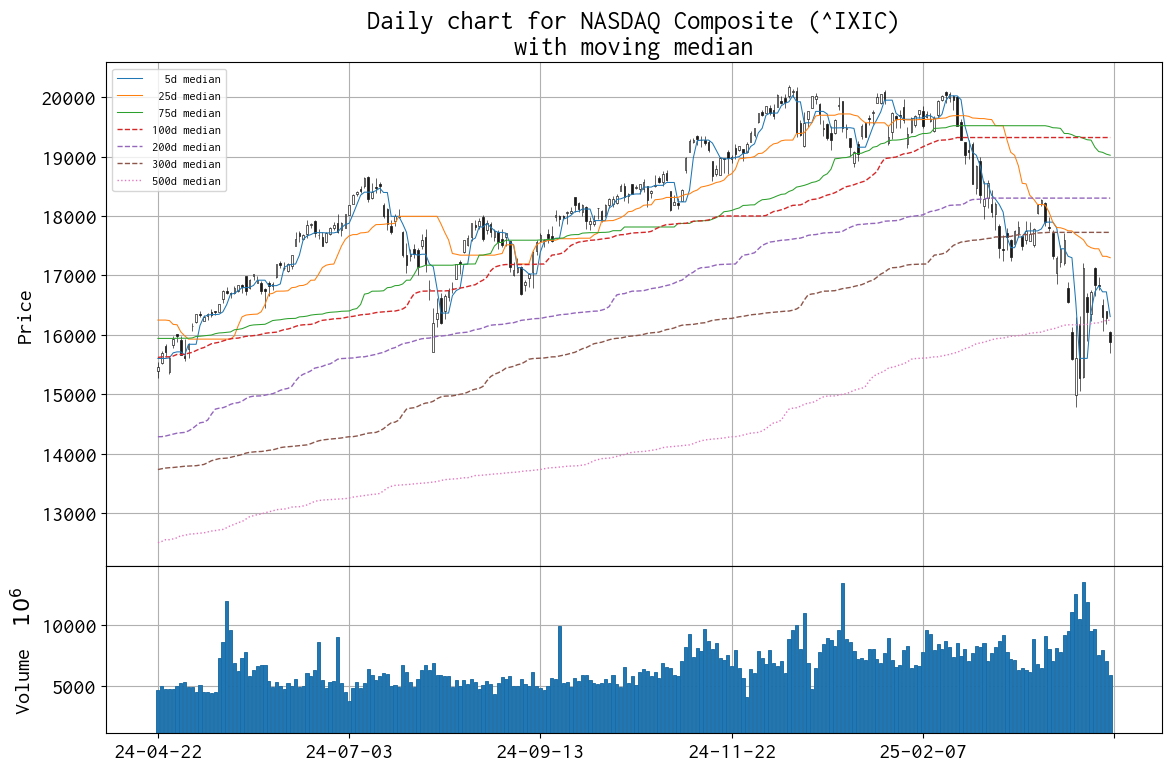

In [5]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig = plt.figure(figsize=(12, 8))
ax = dict()
n = 2
gs = fig.add_gridspec(
    n, 1,
    wspace=0.0, hspace=0.0,
    height_ratios=[3 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex='col')):
    ax[i] = axis
    ax[i].grid()

mm005 = df0['Close'].rolling(5).median()
mm025 = df0['Close'].rolling(25).median()
mm075 = df0['Close'].rolling(75).median()
mm100 = df0['Close'].rolling(100).median()
mm200 = df0['Close'].rolling(200).median()
mm300 = df0['Close'].rolling(300).median()
mm500 = df0['Close'].rolling(500).median()

apds  = [
    mpf.make_addplot(mm005[df.index], width=0.75, label='  5d median', ax=ax[0]),
    mpf.make_addplot(mm025[df.index], width=0.75, label=' 25d median', ax=ax[0]),
    mpf.make_addplot(mm075[df.index], width=0.75, label=' 75d median', ax=ax[0]),
    mpf.make_addplot(mm100[df.index], width=1, linestyle='dashed', label='100d median', ax=ax[0]),
    mpf.make_addplot(mm200[df.index], width=1, linestyle='dashed', label='200d median', ax=ax[0]),
    mpf.make_addplot(mm300[df.index], width=1, linestyle='dashed', label='300d median', ax=ax[0]),
    mpf.make_addplot(mm500[df.index], width=1, linestyle='dotted', label='500d median', ax=ax[0]),
]   

mpf.plot(df, type='candle', style='default', volume=ax[1], datetime_format='%y-%m-%d', addplot=apds, xrotation=0, ax=ax[0])

ax[0].set_title('Daily chart for %s (%s)\nwith moving median' %(ticker.info['longName'], symbol))
ax[0].legend(loc='best', fontsize=9)

plt.tight_layout()
plt.savefig('report_daily_chart_median_%s.png' % code)
plt.show()

In [6]:
df.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-04-17 00:00:00-04:00,16399.970703,16408.509766,16181.169922,16286.450195,7046290000,0.0,0.0
2025-04-21 00:00:00-04:00,16052.799805,16066.791992,15685.334961,15870.900391,5866149000,0.0,0.0


In [7]:
df.tail(2)['Close']

Date
2025-04-17 00:00:00-04:00    16286.450195
2025-04-21 00:00:00-04:00    15870.900391
Name: Close, dtype: float64

In [8]:
df.tail(2)['Close'].diff()

Date
2025-04-17 00:00:00-04:00           NaN
2025-04-21 00:00:00-04:00   -415.549805
Name: Close, dtype: float64

In [9]:
df['Close'].tail(1) - df['Open'].tail(1)

Date
2025-04-21 00:00:00-04:00   -181.899414
dtype: float64

In [10]:
df['Close'].rolling(9).median().tail()

Date
2025-04-14 00:00:00-04:00    16550.609375
2025-04-15 00:00:00-04:00    16550.609375
2025-04-16 00:00:00-04:00    16387.310547
2025-04-17 00:00:00-04:00    16387.310547
2025-04-21 00:00:00-04:00    16387.310547
Name: Close, dtype: float64

In [11]:
df['Close'].rolling(13).median().tail()

Date
2025-04-14 00:00:00-04:00    16831.480469
2025-04-15 00:00:00-04:00    16823.169922
2025-04-16 00:00:00-04:00    16724.460938
2025-04-17 00:00:00-04:00    16550.609375
2025-04-21 00:00:00-04:00    16387.310547
Name: Close, dtype: float64

In [12]:
df['Close'].rolling(26).median().tail()

Date
2025-04-14 00:00:00-04:00    17459.105469
2025-04-15 00:00:00-04:00    17442.995117
2025-04-16 00:00:00-04:00    17386.440430
2025-04-17 00:00:00-04:00    17313.000000
2025-04-21 00:00:00-04:00    17311.139648
Name: Close, dtype: float64

In [13]:
df['Close'].rolling(52).median().tail()

Date
2025-04-14 00:00:00-04:00    18192.405273
2025-04-15 00:00:00-04:00    18128.924805
2025-04-16 00:00:00-04:00    17984.139648
2025-04-17 00:00:00-04:00    17853.839844
2025-04-21 00:00:00-04:00    17806.344727
Name: Close, dtype: float64

## Robust Bollinger's bands

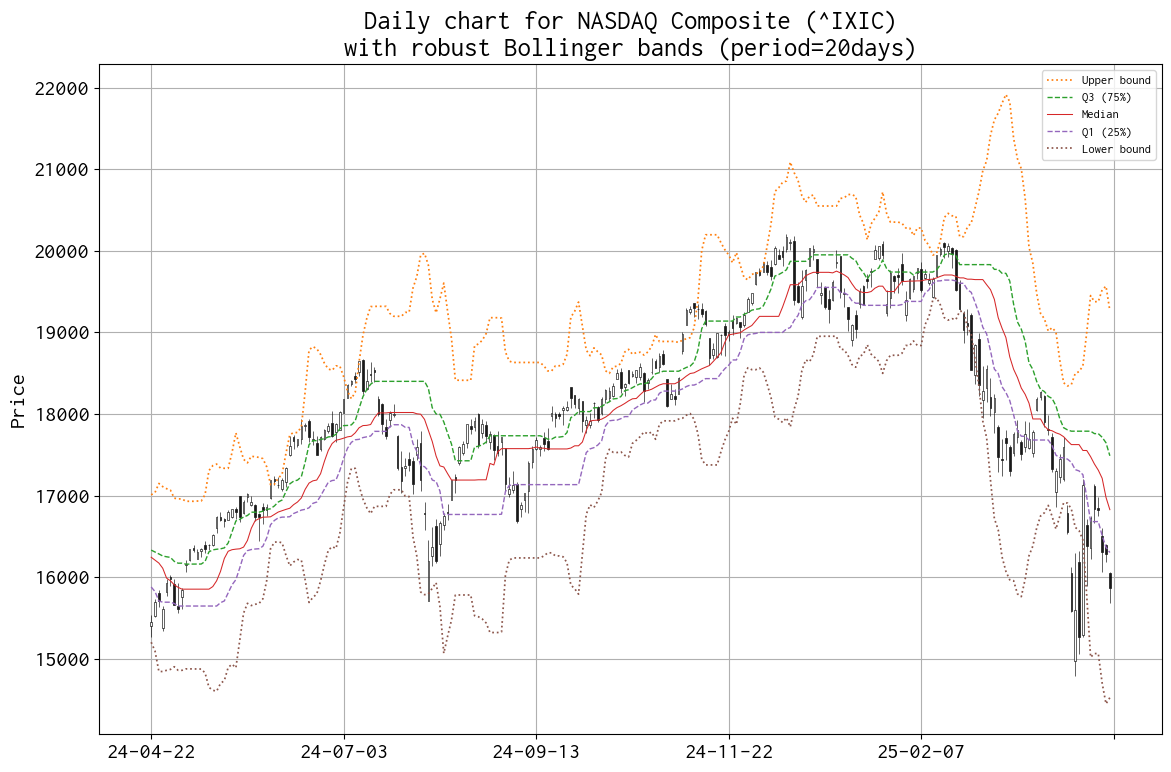

In [14]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 8))

# Bollinger bands
period = 20
mv_median = df0['Close'].rolling(period).median()
mv_q1 = df0['Close'].rolling(period).quantile(.25)
mv_q3 = df0['Close'].rolling(period).quantile(.75)
mv_iqr = mv_q3 - mv_q1
mv_lower = mv_q1 - mv_iqr * 1.5
mv_upper = mv_q3 + mv_iqr * 1.5

apds  = [
    mpf.make_addplot(mv_upper[df.index], width=1.25, color='C1', linestyle='dotted', label='Upper bound', ax=ax),
    mpf.make_addplot(mv_q3[df.index], width=1, color='C2', linestyle='dashed', label='Q3 (75%)', ax=ax),
    mpf.make_addplot(mv_median[df.index], width=0.75, color='C3', label='Median', ax=ax),
    mpf.make_addplot(mv_q1[df.index], width=1, color='C4', linestyle='dashed', label='Q1 (25%)', ax=ax),
    mpf.make_addplot(mv_lower[df.index], width=1.25, color='C5', linestyle='dotted', label='Lower bound', ax=ax),
]   

mpf.plot(df, type='candle', style='default', addplot=apds, datetime_format='%y-%m-%d', xrotation=0, ax=ax)

ax.grid()
ax.legend(loc='best', fontsize=9)

try:
    ax.set_title('Daily chart for %s (%s)\nwith robust Bollinger bands (period=%ddays)' % (ticker.info['longName'], symbol, period))
except KeyError:
    ax.set_title('Daily chart for %s\nwith robust Bollinger bands (period=%ddays)' % (symbol, period))

plt.tight_layout()
plt.savefig('report_daily_chart_bollinger_robust_%s.png' % code)
plt.show()

## ヒストグラムと Q-Q プロット

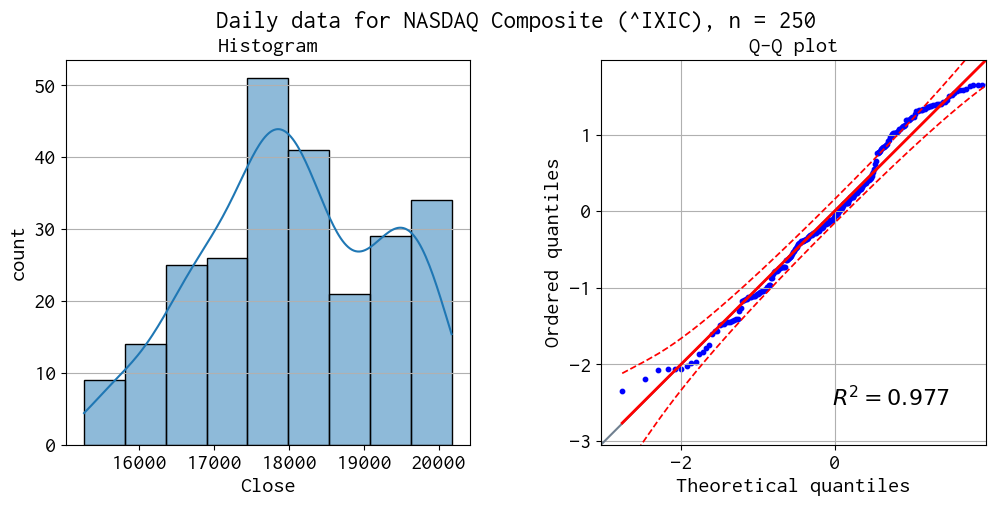

In [15]:
plt.rcParams['font.size'] = 16

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(
    df['Close'],
    kde=True,
    ax=axes[0]
)

# ヒストグラム
axes[0].set_xlabel("Close")
axes[0].set_ylabel("count")
axes[0].grid(axis = 'y')
axes[0].set_title('Histogram', fontsize=16)

# Q-Q プロット
pg.qqplot(df['Close'], s=10,  ax=axes[1])
axes[1].set_title('Q-Q plot', fontsize=16)
axes[1].grid()

plt.suptitle('Daily data for %s (%s), n = %d' % (ticker.info['longName'], symbol, len(df)), fontsize=18)
plt.subplots_adjust(wspace=0.3)
plt.savefig('report_daily_histogram_qqplot_%s.png' % code)
plt.show()